# House Pricing Regression

ref:
1. https://github.com/PacktPublishing/Python-for-Finance-Cookbook/tree/master/Chapter%2008
2. https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda#executive-summary

If you’re looking for a standard boilerplate to analyse tabular data for regression task, this is for you!

There are 9 steps in this notebook:
1. Load and Manage Data
2. Exploratory Data Analysis
3. Split to Train and Test
4. Deal with Missing Values
5. Encode Categorical Variables
6. Fit Decision Tree Regression
7. (optional) under/over-sampling for imbalanced data
8. Investigate Feature Importance
9. Implement Sklearn Pipeline
10. Hyperparameter Tuning



# Load and Manage Data

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("https://raw.githubusercontent.com/liyenhsu/Kaggle-House-Prices/master/data/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/liyenhsu/Kaggle-House-Prices/master/data/test.csv")

train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [2]:
# check dataframe memory usage
train.memory_usage(deep=True)

# # change type to save up memory
# object_columns = df.select_dtypes(include='object').columns
# df[object_columns] = df[object_columns].astype('category')

Index              128
Id               11680
MSSubClass       11680
MSZoning         86190
LotFrontage      11680
                 ...  
MoSold           11680
YrSold           11680
SaleType         86371
SaleCondition    92210
SalePrice        11680
Length: 82, dtype: int64

In [3]:
X = train.copy()
X_id = X.pop("Id")
y = X.pop('SalePrice')

# Exploratory Data Analysis

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [5]:
# summary statistics
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460,NaN,NaN,NaN,730.5,421.61,1,365.75,730.5,1095.25,1460
MSSubClass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
LotArea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460,NaN,NaN,NaN,6.32192,2.70363,1,5,6,8,12
YrSold,1460,NaN,NaN,NaN,2007.82,1.3281,2006,2007,2008,2009,2010
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


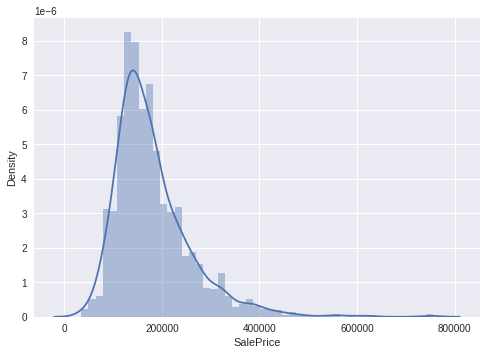

In [6]:
# distribution of sale price
sns.distplot(train["SalePrice"], hist=True)

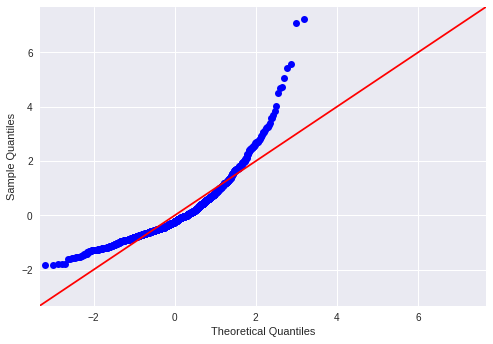

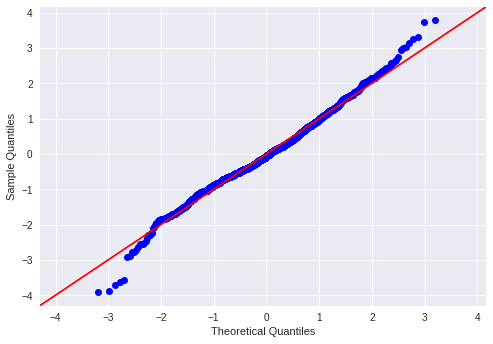

In [44]:
# q-q plot of sale price
import statsmodels.api as sm

_ = sm.qqplot(train["SalePrice"], fit=True, line="45")
_ = sm.qqplot(np.log(train["SalePrice"]), fit=True, line="45")

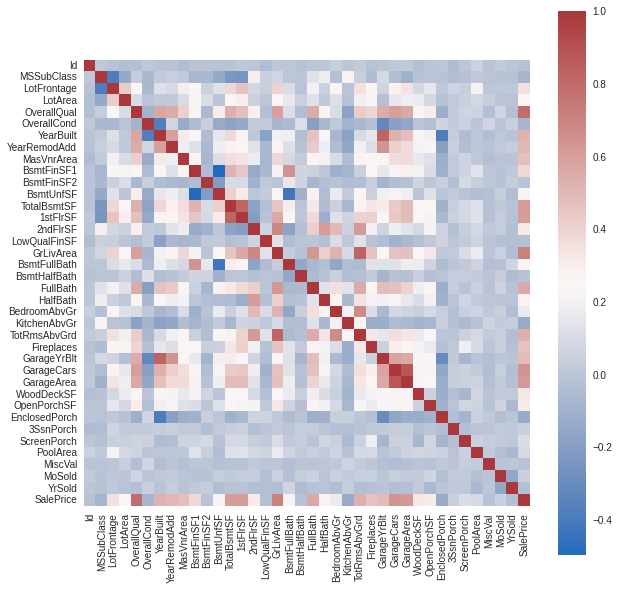

In [7]:
# correlation heatmap
corr_mat = train.select_dtypes(include='number').corr()    
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, square=True, cmap="vlag")

Text(0.5, 1.05, 'Pairplot of selected variables')

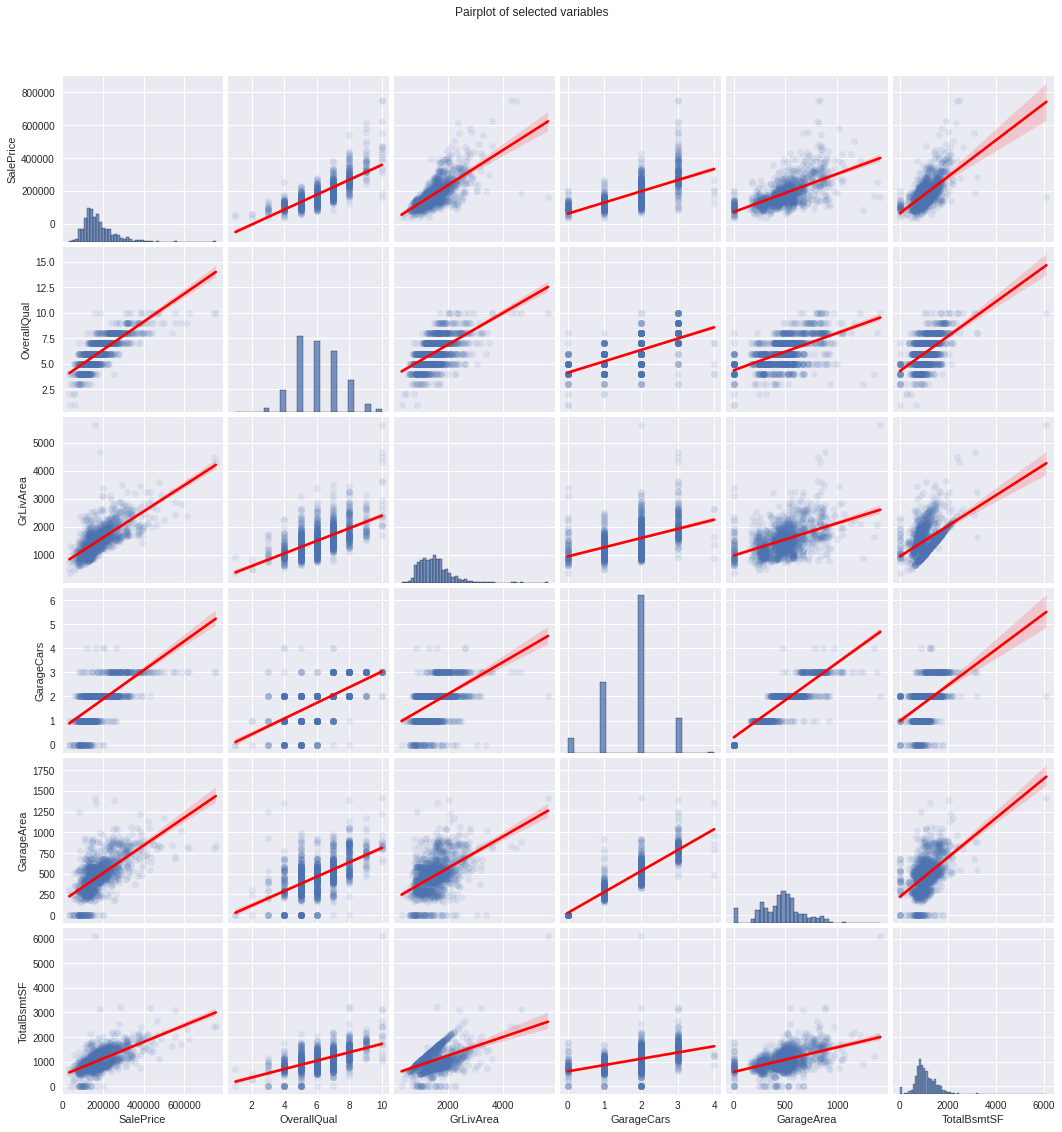

In [30]:
# pairplot of selected variables
high_corr_cols = corr_mat["SalePrice"].apply(lambda x: abs(x)).sort_values(ascending=False).head(6).index.tolist()
pair_plot = sns.pairplot(train[high_corr_cols], kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05)

In [31]:
# # distribution of age by gender
# fig, ax = plt.subplots()
# sns.distplot(df[df.sex=="Male"]["age"], hist=False, color="green", kde_kws={'shade': True}, ax=ax)
# sns.distplot(df[df.sex=="Female"]["age"], hist=False, color="blue", kde_kws={'shade': True}, ax=ax)
# ax.legend(["Male", "Female"])

In [32]:
# # distribution of limit balance per education level by sex
# ax = sns.violinplot(x='education', y='limit_bal', 
#                     hue='sex', split=True, data=df)
# ax.set_title('Distribution of limit balance per education level', 
#              fontsize=16)

In [33]:
# # distribution of target by sex
# ax = sns.countplot('default_payment_next_month', hue='sex', 
#                    data=df, orient='h')
# ax.set_title('Distribution of the target variable', fontsize=16)

In [34]:
# # percentage of target by education
# ax = df.groupby('education')['default_payment_next_month'] \
#        .value_counts(normalize=True) \
#        .unstack() \
#        .plot(kind='barh', stacked='True')
# ax.set_title('Percentage of default per education level', 
#              fontsize=16)
# ax.legend(title='Default', bbox_to_anchor=(1,1)) 

# Split to Training and Test Dataset

In [37]:
from sklearn.model_selection import train_test_split

# ensure uniform label distribution for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Deal with Missing Values

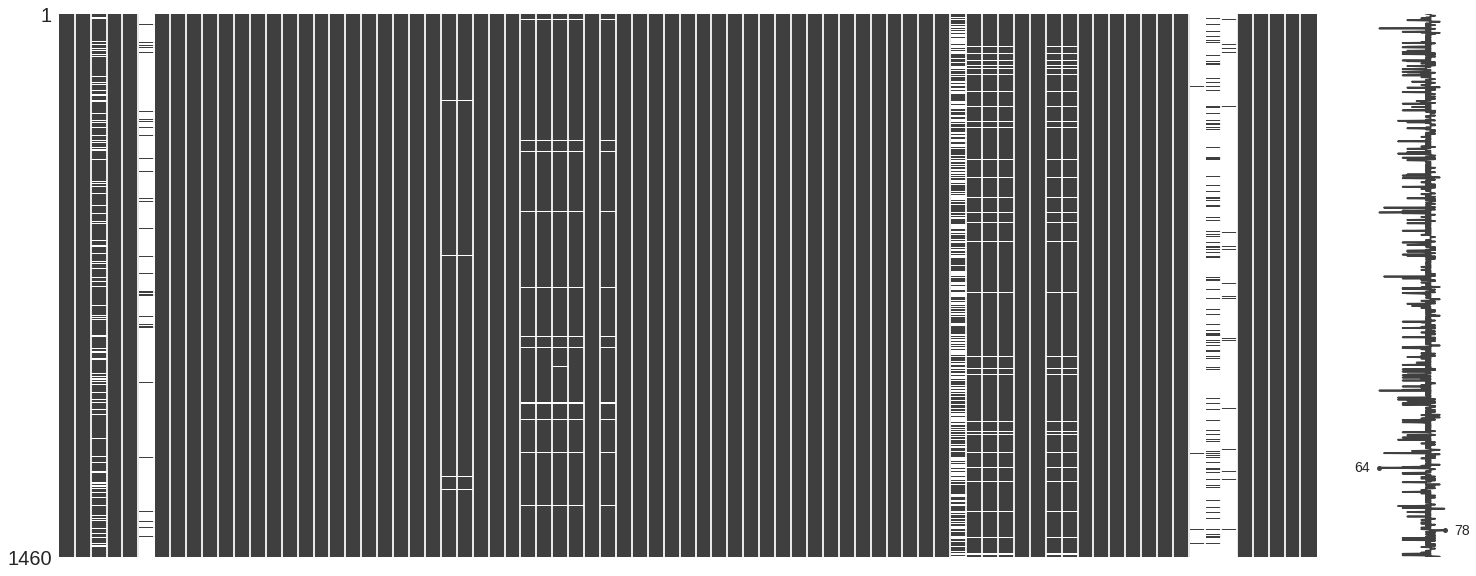

In [56]:
# Visualise Missing Data
import missingno
missingno.matrix(X)

In [58]:
# Impute Missing Values

from sklearn.impute import SimpleImputer

# impute numerical features
NUM_FEATURES = X.select_dtypes(include='number').columns.tolist()
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

# impute categorical variables
CAT_FEATURES = X.select_dtypes(include='object').columns.tolist()
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

# Encoding Categorical Variables

In [60]:
# Fit One Hot Encoder and Column Transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

CAT_FEATURES = X.select_dtypes(include='object').columns.tolist()
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')
one_hot_transformer = ColumnTransformer([("one_hot", one_hot_encoder, CAT_FEATURES)]) 
one_hot_transformer.fit(X)
col_names = one_hot_transformer.get_feature_names()

# transform train data
X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train), 
                           columns=col_names, 
                           index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1) \
                .drop(CAT_FEATURES, axis=1)

# transform test data
X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test), 
                          columns=col_names, 
                          index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1) \
               .drop(CAT_FEATURES, axis=1)

# alternative. But can't use in sklearn pipeline
# pd.get_dummies(X_train, prefix_sep='_', drop_first=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
# # need to encode some categorical variables as ordinal numbers: PoolQC,
# from sklearn.preprocessing import OrdinalEncoder

# ordinal_encoder = OrdinalEncoder()

# X["PoolQC"].value_counts()

# Fit Decision Tree Regression

In [66]:
# Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train_ohe, y_train)
y_test_pred = tree_regressor.predict(X_test_ohe)

# Evaluate Regressor
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(mae, mse, r2)

27351.116438356163 1816205340.1643836 0.7632166753921636


In [67]:
# Visualise Decision Tree
from sklearn.tree import export_graphviz
from io import StringIO
from ipywidgets import Image
import pydotplus

LABELS = ['No Default', 'Default']
small_tree = DecisionTreeRegressor(max_depth=3, 
                                    random_state=42)
small_tree.fit(X_train_ohe, y_train)

tree_dot = StringIO()
export_graphviz(small_tree, feature_names=X_train_ohe.columns,
                class_names=LABELS, rounded=True, out_file=tree_dot,
                proportion=False, precision=2, filled=True)
tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())  
tree_graph.set_dpi(300) 
Image(value=tree_graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x1fU\x00\x00\x06\x12\x08\x06\x00\x00\x00tv\x97\xb9\x…

# (Optional) Under/Over-sampling for Imbalanced Data

In [ ]:
# # Under-sampling
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler()
# X_rus, y_rus = rus.fit_resample(X_train_ohe, y_train)
# tree_classifier.fit(X_rus, y_rus)

In [ ]:
# # Over-sampling
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# ros = RandomOverSampler()
# X_ros, y_ros = ros.fit_resample(X_train_ohe, y_train)
# tree_classifier.fit(X_ros, y_ros)

# X_smote, y_smote = SMOTE().fit_resample(X_train_ohe, y_train)
# tree_classifier.fit(X_smote, y_smote)

# X_adasyn, y_adasyn = ADASYN().fit_resample(X_train_ohe, y_train)
# tree_classifier.fit(X_adasyn, y_adasyn)


In [ ]:
# # balanced classifier weight
# tree_classifier = DecisionTreeClassifier(random_state=42, class_weight="balanced")


# Investigate Feature Importance

There are three methods:
1. Sklearn feature importance
2. Permutation importance


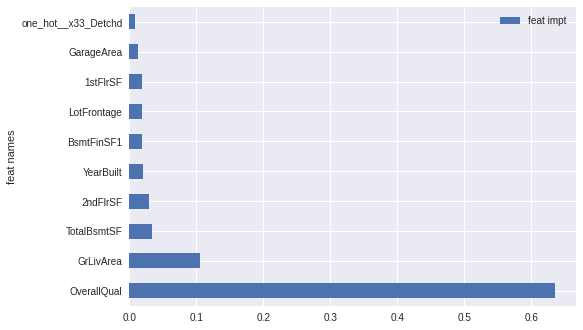

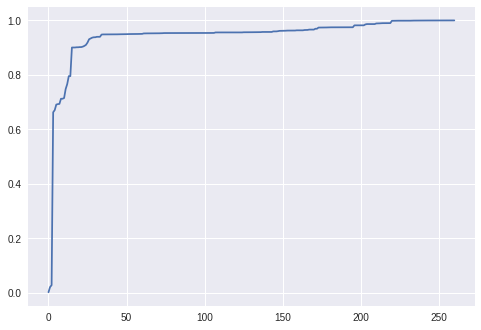

In [111]:
# Sklearn feature importance

# tree_classifier
feature_names = X_train_ohe.columns
impt_df = pd.DataFrame(zip(feature_names, tree_regressor.feature_importances_), columns=["feat names", "feat impt"])
impt_df = impt_df.sort_values("feat impt", ascending=False).set_index("feat names")

impt_df.head(10).plot.barh()
# plt.barh(feature_names, tree_regressor.feature_importances_)
plt.show()

plt.plot(np.cumsum(tree_regressor.feature_importances_))
plt.show()

     |████████████████████████████████| 106 kB 16.1 MB/s 


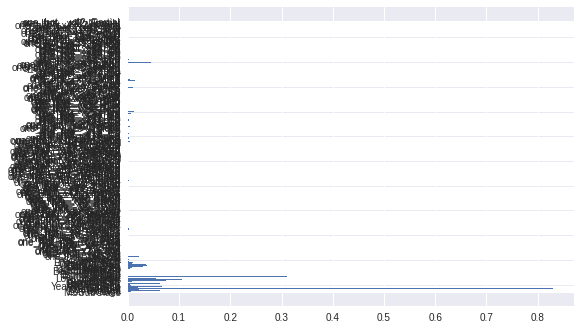

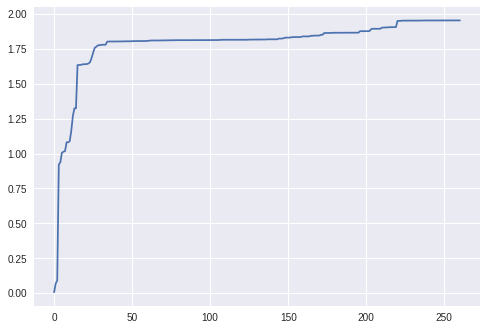

In [70]:
# Permutation Importance
!pip install eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(tree_regressor, n_iter = 25, 
                             random_state=42)
perm.fit(X_train_ohe, y_train)

feature_names = X_train_ohe.columns
plt.barh(feature_names, perm.feature_importances_)
plt.show()

plt.plot(np.cumsum(perm.feature_importances_))
plt.show()

# Implement Sklearn Pipeline
integrate the first 6 steps

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# LOAD DATA
train = pd.read_csv("https://raw.githubusercontent.com/liyenhsu/Kaggle-House-Prices/master/data/train.csv")

# SPLIT DATA
X = train.copy()
X_id = X.pop("Id")
y = X.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

# PREPROCESSING
num_features = X.select_dtypes(include='number') \
                      .columns \
                      .to_list()
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('minmaxscaler', MinMaxScaler())
    # ('standardscaler', StandardScaler())
])

cat_features = X.select_dtypes(include='object') \
                      .columns \
                      .to_list()
cat_list = [list(X[col].dropna().unique()) for col in cat_features]
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

# CLASSIFIER
dec_tree = DecisionTreeRegressor(random_state=42)

# COMPLETE PIPELINE
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', dec_tree)])

# Evaluate Pipeline
tree_pipeline.fit(X_train, y_train)
y_pred_test = tree_pipeline.predict(X_test)
y_pred_test

array([158500., 424870., 128000., 159000., 285000.,  86000., 200000.,
       148500.,  88000., 142953., 189950., 111000., 110000., 201000.,
       179000., 139400., 196500., 136000., 113000., 191000., 104900.,
       233230., 188000., 109900., 179900., 177500., 164990., 109900.,
       163990., 193879., 135000., 233000., 189000., 114500., 250000.,
       119000., 104900., 155000., 290000., 124000., 109500., 268000.,
       114500., 340000., 126500., 193500., 114500., 127500., 485000.,
       128500., 111000., 193500., 116000., 424870., 143000., 240000.,
       193000., 140000., 142500., 112500.,  72500., 155000., 337000.,
       266000., 249700., 240000., 100000., 316600., 123600., 168500.,
       118964., 127500.,  97000.,  90000., 446261., 181000., 290000.,
       260000., 139000., 120500.,  83000.,  98300., 126500.,  52000.,
       159000., 135000., 270000., 206300., 143000., 200141., 124900.,
       197500., 130500., 271000., 100000., 185000., 130000., 155000.,
       204000., 2380

# Hyperparameter Tuning

In [73]:
# Tune with Grid Search and k-fold cross validation

from sklearn.model_selection import (GridSearchCV, cross_val_score, 
                                     RandomizedSearchCV, cross_validate, 
                                     StratifiedKFold)
from sklearn import metrics

# Evaluate Pipeline once
# cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
#                scoring=['accuracy', 'precision', 'recall', 
#                         'roc_auc'])

# Define Cross-Validation and Grid Search
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)
param_grid = {'regressor__max_depth': range(9, 11),
              'regressor__min_samples_leaf': range(9, 11)}
regressor_gs = GridSearchCV(tree_pipeline, param_grid, scoring='r2', 
                             cv=k_fold, n_jobs=-1, verbose=1)

regressor_gs.fit(X_train, y_train)

# Evaluate
print(f'Best parameters: {regressor_gs.best_params_}') 
print(f'R2 (Training set): {regressor_gs.best_score_:.4f}') 
print(f'R2 (Test set): {metrics.r2_score(y_test, regressor_gs.predict(X_test)):.4f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 10}
R2 (Training set): 0.7513
R2 (Test set): 0.7980


In [74]:
# Evaluate
y_test_pred = regressor_gs.predict(X_test)

# Evaluate Regressor
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(mae, mse, r2)

24275.366270338804 1549555554.9150586 0.7979804883052928


In [ ]:
# More Complex Grid Search. Add Other models
from sklearn.model_selection import (GridSearchCV, cross_val_score, 
                                     RandomizedSearchCV, cross_validate, 
                                     StratifiedKFold)
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.svm import SVR

import numpy as np

k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

param_grid = [
    {'regressor': [DecisionTreeRegressor()],
      'regressor__max_depth': range(9, 11),
      'regressor__min_samples_leaf': range(9, 11)},
    {'regressor': [RandomForestRegressor()],
      'regressor__max_depth': range(9, 11),
      'regressor__min_samples_leaf': range(9, 11)},
    {'regressor': [GradientBoostingRegressor()],
     'regressor__n_estimators': np.linspace(100, 1000, 10, dtype=int),
     'regressor__learning_rate': np.arange(0.05, 0.31, 0.05),
     'regressor__max_depth': np.arange(3, 11, 1, dtype=int),
     'regressor__min_samples_split': np.linspace(0.1, 0.5, 12),},
    {'regressor': [XGBRegressor()],
     'regressor__n_estimators': np.linspace(100, 1000, 10, dtype=int),
     'regressor__learning_rate': np.arange(0.05, 0.31, 0.05),
     'regressor__max_depth': np.arange(3, 11, 1, dtype=int),
     'regressor__min_child_weight': np.arange(1, 8, 1, dtype=int),
     'LGBMRegressor': np.linspace(0.3, 1, 7)},
    {'regressor': [LGBMRegressor()],
     'regressor__n_estimators': np.linspace(100, 1000, 10, dtype=int),
     'regressor__learning_rate': np.arange(0.05, 0.31, 0.05),
     'regressor__max_depth': np.arange(3, 11, 1, dtype=int),
     'regressor__colsample_bytree': np.linspace(0.3, 1, 7)},
    {'regressor': [StackingRegressor(
          [('dec_tree', DecisionTreeRegressor()), ('log_reg', RandomForestRegressor())],
          final_estimator=DecisionTreeRegressor(),
          cv=k_fold,
          n_jobs=-1 
        )]
    }
]

regressor_gs = GridSearchCV(tree_pipeline, param_grid, scoring='r2', 
                             cv=k_fold, n_jobs=-1, verbose=1)

regressor_gs.fit(X_train, y_train)

# Evaluate
print(f'Best parameters: {regressor_gs.best_params_}') 
print(f'R2 (Training set): {regressor_gs.best_score_:.4f}') 
print(f'R2 (Test set): {metrics.r2_score(y_test, regressor_gs.predict(X_test)):.4f}')

In [78]:
# Bayesian Optimisation
# need access to X_train_ohe and y_train
from lightgbm import LGBMRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold

N_FOLDS = 5
MAX_EVALS = 5# 200
lgbm_param_grid = {'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'goss']),
                   'max_depth': hp.choice('max_depth', [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                   'n_estimators': hp.choice('n_estimators', [10, 50, 100, 300, 750, 1000]),
                   'is_unbalance': hp.choice('is_unbalance', [True, False]),
                   'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
                   'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
                  }

def objective(params, n_folds=N_FOLDS, random_state=42):
    model = LGBMRegressor(**params)
    model.set_params(random_state=random_state)
    k_fold = StratifiedKFold(n_folds, shuffle=True, 
                             random_state=random_state)
    metrics = cross_val_score(model, X_train_ohe, y_train, 
                              cv=k_fold, scoring='r2')
    loss = -1 * metrics.mean()
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
trials = Trials()
best_set = fmin(fn=objective,
                space=lgbm_param_grid,
                algo=tpe.suggest,
                max_evals=MAX_EVALS,
                trials=trials)
best_set

# we can inspect trials.results to see how the samplings evolved

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



 20%|██        | 1/5 [00:00<00:03,  1.16it/s, best loss: 8.106478496737198e+65]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



 40%|████      | 2/5 [00:01<00:02,  1.40it/s, best loss: -0.8352975521761266]  

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



 60%|██████    | 3/5 [00:03<00:02,  1.41s/it, best loss: -0.8352975521761266]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



 80%|████████  | 4/5 [00:04<00:01,  1.06s/it, best loss: -0.8352975521761266]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,



100%|██████████| 5/5 [00:04<00:00,  1.02it/s, best loss: -0.8384515994164726]


{'boosting_type': 0,
 'colsample_bytree': 0.5849193706561403,
 'is_unbalance': 0,
 'learning_rate': 0.2522695163356307,
 'max_depth': 7,
 'n_estimators': 0}